In [1]:
import os
import math
import json
import igraph

import numpy as np
import pandas as pd
import networkx as nx

from pprint import pprint

from itertools import groupby
from itertools import combinations

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.datasets.base import Bunch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import manhattan_distances

from sklearn.cluster import KMeans, MiniBatchKMeans

from networkx.readwrite import json_graph

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
from util import Ean
ean_checker = Ean()

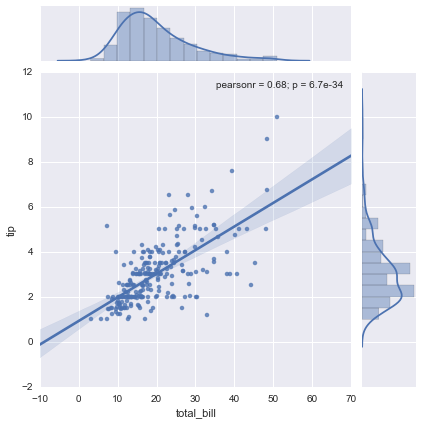

In [3]:
import seaborn as sns

# Load one of the data sets that come with seaborn
tips = sns.load_dataset("tips")

sns.jointplot("total_bill", "tip", tips, kind='reg');
 

In [4]:
def abs_dist(attr='price'):
    def _inner(a, b):
        return abs(a[attr] - b[attr])
    return _inner

In [5]:
def equal_dist(attr='name'):
    def _inner(a, b):
        if a[attr] == b[attr]:
            return 0.0
        else:
            return 1.0
    return _inner

In [6]:
class Distance:
    distances = [
        abs_dist(attr='price'),
        equal_dist(attr='name'),
    ]
    def __call__(self, a, b):
        distances = []
        for distance in self.distances:
            distances.append(distance(a, b))
        return np.array(distances)

## clean up prices

In [7]:
def convert_price(price):
    price = str(price)
    if ',' in price:
        if '.' in price:
            price = price.replace('.', '')
        price = price.replace(',', '.')
        
    if ' EUR' in price:
        price = price.replace(' EUR', '')

    try:
        return float(price)
    except ValueError:
        # print('<{}>'.format(price))
        return None

## read products feed

In [8]:
products = pd.read_csv('products.csv', error_bad_lines=False, converters={'price': convert_price})
products = products.drop('Unnamed: 0', 1)
products = products[~products.price.isnull()]
# list(products.columns)

//anaconda/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


## group by ean and get samples with at least 5 items

In [9]:
# dunno why this is so slow
# ean_grouped = products.groupby('ean').filter(lambda x: len(x) > 5)

In [10]:
good_eans = pd.Series(ean for ean, eans in groupby(products.ean) if len(list(eans)) > 5)
sample_products = products[products.ean.isin(good_eans.sample(n=10))]

## create sample dataset

In [11]:
dataset = Bunch()
dataset.data = sample_products
dataset.target = sample_products.ean
dataset.true_k = np.unique(dataset.target).shape[0]

## feature extraction

In [12]:
class EmptyFitMixin:
    def fit(self, x, y=None):
        return self

In [13]:
class ItemSelector(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def __init__(self, key):
        self.key = key

    def transform(self, df):
        values = np.array(df[self.key])
        return values.reshape(values.shape[0], 1)

In [14]:
class TextExtractor(BaseEstimator, TransformerMixin, EmptyFitMixin):
    """Extract the text from a product in a single pass.

    Takes a pandas dataframe and produces a series of texts
    from joined columns defined in `text_cols`.
    """
    def __init__(self, text_cols=['name', 'shortdescription', 'brand', 'type']):
        self.text_cols = text_cols
    
    def transform(self, data):
        def join(items):
            return ' '.join([str(item) for item in items])
        
        texts = data[self.text_cols].apply(join, axis=1)
        return texts

In [15]:
class CosineDistance(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        cosine_similarity = linear_kernel(X, X)
        return 1.0 - cosine_similarity

In [16]:
class NumericDistance(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        return manhattan_distances(X)

In [17]:
class CombineDistances(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        parts_num = X.shape[1] / X.shape[0]
        parts = np.split(X, parts_num, axis=1)
        # combine with euclidean distance
        return np.sqrt(np.sum(p**2 for p in parts))

In [18]:
simple_features = FeatureUnion(
    transformer_list=[

        # Pipeline for pulling features from the text columns
        ('text_tfidf', Pipeline([
            # Extract text data from products
            ('text', TextExtractor(text_cols=['name', 'brand', 'type'])),
            ('tfidf', TfidfVectorizer()),
            ('svd', TruncatedSVD(2)),
            ('normalizer', Normalizer(copy=False)),
        ])),

        # Pipeline for price
        ('price', Pipeline([
            ('selector', ItemSelector(key='price')),
        ])),
    ],
)

In [19]:
pipeline_simple = Pipeline([
    # Use FeatureUnion to extract features from text and price
    ('features', simple_features),
    # Use kmeans clustering on the combined features
    ('kmeans', KMeans(n_clusters=dataset.true_k, init='k-means++', max_iter=100, n_init=1)),
])

In [20]:
#pp = sns.pairplot(sproducts, hue="ean", vars=['text_1', 'text_2', 'price'])

In [21]:
distance_features = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            # Pipeline for pulling features from the text columns
            # and build a cosine distance matrix from it
            ('text_tfidf', Pipeline([
                ('text', TextExtractor(text_cols=['name', 'brand', 'type'])),
                ('tfidf', TfidfVectorizer()),
                ('tfidf_distance', CosineDistance()),
            ])),

            # Pipeline for price
#            ('price', Pipeline([
#                ('selector', ItemSelector(key='price')),
#                ('price_distance', NumericDistance()),
#                ('normalizer', Normalizer(copy=False)),
#            ])),
        ],
    )),
    ('combine', CombineDistances()),
])

In [22]:
pipeline_distances = Pipeline([
    # Use FeatureUnion to combine the features from text and price
    ('distances', distance_features),
    # Use kmeans clustering on the combined features
    ('kmeans', KMeans(n_clusters=dataset.true_k, init='k-means++', max_iter=100, n_init=1)),
])

In [24]:
def evaluate_clustering(pipeline, dataset):
    pipeline.fit(dataset.data)
    X = pipeline.transform(dataset.data)
    predicted = pipeline.fit_predict(dataset.data, dataset.target)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataset.target, predicted))
    print("Completeness: %0.3f" % metrics.completeness_score(dataset.target, predicted))
    print("V-measure: %0.3f" % metrics.v_measure_score(dataset.target, predicted))
    print("Adjusted Rand-Index: %.3f"
          % metrics.adjusted_rand_score(dataset.target, predicted))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, predicted, sample_size=1000))

In [25]:
evaluate_clustering(pipeline_simple, dataset)

Homogeneity: 0.738
Completeness: 0.778
V-measure: 0.757
Adjusted Rand-Index: 0.702
Silhouette Coefficient: 0.914


In [26]:
evaluate_clustering(pipeline_distances, dataset)

Homogeneity: 0.900
Completeness: 0.961
V-measure: 0.929
Adjusted Rand-Index: 0.783
Silhouette Coefficient: 0.893


## distances to graph

In [27]:
# calc distances
X = distance_features.fit_transform(dataset.data, dataset.target)

In [28]:
# convert distance matrix to graph
dt = [('distance', float)]
G = nx.from_numpy_matrix(X.view(dt))

In [29]:
# create node color lookup dict
eans = set(dataset.data.ean)
colors = [int(c.replace('#', '0x'), 16) for c in sns.color_palette("hls", len(eans)).as_hex()]
ean_colors = {e: c for e, c in zip(eans, colors)}
node_colors = dict(enumerate((ean_colors[ean] for ean in dataset.data.ean)))

## visualize distance graph with igraph and webgl

In [30]:
# create json representation of graph, reformat node format and add color to nodes
graph_json = json_graph.node_link_data(G)
graph_json['nodes'] = {n['id']: {'id': n['id'], 'color': node_colors[n['id']]} for n in graph_json['nodes']}

In [31]:
# reduce number of edges and rename links to edges
#graph_json['edges'] = [l for l in graph_json['links'] if l['distance'] < 1.0 and l['distance'] > 0.1]
graph_json['edges'] = [l for l in graph_json['links'] if l['distance'] < 0.8 and l['distance'] > 0.0]
#graph_json['edges'] = graph_json['links']

In [32]:
len(graph_json['edges'])

1025

In [33]:
igraph.draw(graph_json, size=(800, 600), directed=False)

## visualize distance graph with d3 and svg

In [47]:
# create json representation of graph, reformat node format and add color to nodes
graph_json = json_graph.node_link_data(G)
graph_json['nodes'] = [{'id': n['id'], 'color': node_colors[n['id']]} for n in graph_json['nodes']]
pprint(graph_json['nodes'][:2])
# filter links
graph_json['links'] = [l for l in graph_json['links'] if l['distance'] < 0.6 and l['distance'] > 0.0]
pprint(graph_json['links'][:2])

[{'color': 7952347, 'id': 0}, {'color': 7952347, 'id': 1}]
[{'distance': 1.1102230246251565e-16, 'source': 0, 'target': 0},
 {'distance': 0.4725765292519739, 'source': 0, 'target': 1}]


In [48]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

In [49]:
from IPython.display import Javascript
#runs arbitrary javascript, client-side
Javascript("window.graph_json={};".format(json.dumps(graph_json)))

<IPython.core.display.Javascript object>

In [52]:
%%javascript
/*
require(['d3'], function(d3){
  //a weird idempotency thing
  $("#chart1").remove();
  //create canvas
  var style = [
    '<style>',
    '.node {',
    '  stroke: #fff;',
    '  stroke-width: 1.5px;',
    '}',
    '.link {',
    '  stroke: #999;',
    '  stroke-opacity: .6;',
    '}',
    '</style>'
  ].join('\n');

  //element.append(style);
  element.append("<h1>distance graph</h1>")
  element.append("<div id='chart1'></div>");
        
  var width = 960,
    height = 500;

  var color = d3.scale.category20();

  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  var svg = d3.select("#chart1").append("svg")
    .attr("width", width)
    .attr("height", height);

  var graph = window.graph_json;

  force
    .nodes(graph.nodes)
    .links(graph.links)
    .start();

  var link = svg.selectAll(".link")
    .data(graph.links)
  .enter().append("line")
    .attr("class", "link")
    .style("stroke", "#999")
    .style("stroke-width", function(d) { return 1.0; });
//    .style("stroke-width", function(d) { return d.distance / 1.0; });

  var node = svg.selectAll(".node")
    .data(graph.nodes)
  .enter().append("circle")
    .attr("class", "node")
    .attr("r", 5)
    .style("fill", function(d) { return color(d.color); })
    .call(force.drag);

  node.append("title")
    .text(function(d) { return d.id; });

  force.on("tick", function() {
    link.attr("x1", function(d) { console.log('foobar: ' + d.source.x);return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; });

    node.attr("cx", function(d) { return d.x; })
        .attr("cy", function(d) { return d.y; });
  });
});
*/

<IPython.core.display.Javascript object>

## manual distance calculations

In [485]:
distance = Distance()
distances = []
for a, b in combinations(dataset.data, 2):
    pass
    #distances.append(distance(a, b))
len(distances)

0